# EDA

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from scipy import stats
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import beta

In [ ]:
# The dataset was retrieved from https://www.kaggle.com/datasets/datasetengineer/indfd-pm-dt/data. 
# From the dataset we only used 3 columns: Temperature readings, humidity levels, acoustic signals and saved them in training_data.csv
# The data was saved as an artifact when training an IsolationForest model with MLflow in the following folder:

df=pd.read_csv("mlflow\mlartifacts\1\3e99f6f4aa5c4d55a2752924e0611513\artifacts\training_data\training_data.csv")

df

,Temperature_Readings,Humidity_Levels,Acoustic_Signals
0,23.865396,31.404880,42.709897
1,27.332215,23.516423,56.146535
2,29.483668,27.537668,80.487979
3,19.005118,14.888160,63.602072
4,32.096101,22.703902,47.574150
...,...,...,...
43820,32.978580,8.003138,73.282519
43821,26.184765,21.218103,38.305330
43822,34.318023,42.714236,39.245290
43823,36.644425,27.355317,50.495128


In [16]:
df.describe()

,Temperature_Readings,Humidity_Levels,Acoustic_Signals
count,43825.000000,43825.000000,43825.000000
mean,30.013493,20.170006,49.818038
std,5.003203,12.173021,14.957175
min,10.277032,0.079138,-11.435987
25%,26.618437,10.829864,39.766143
50%,30.037904,18.062967,49.815537
75%,33.411046,27.454614,59.909451
max,45.000000,88.364871,119.250894


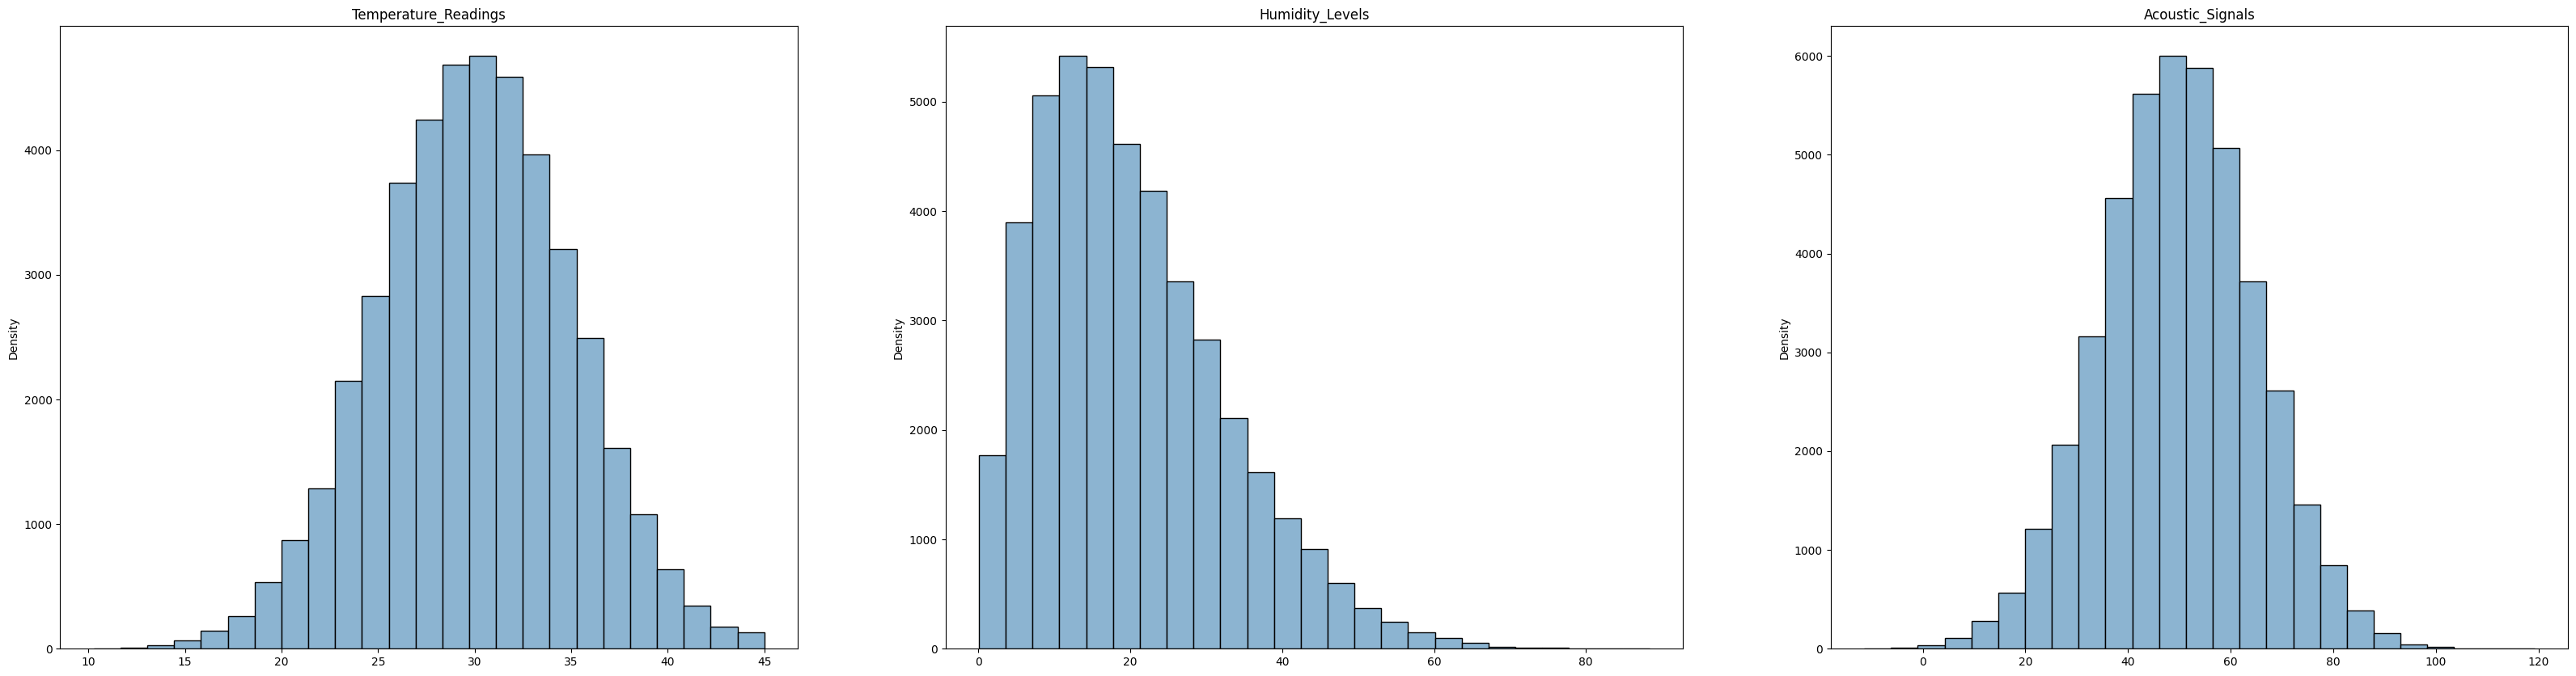

In [ ]:
columns = df.columns
grid = gridspec.GridSpec(1, 3)

plt.figure(figsize=(40,10))

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    plt.hist(df[col], bins=25, edgecolor='black')
 
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
    
plt.show()

In [19]:
print(f"Skewness: {stats.skew(df['Humidity_Levels'])}")
print(f"Kurtosis: {stats.kurtosis(df['Humidity_Levels'])}")

Skewness: 0.8297463582012664
Kurtosis: 0.4890223103444655


There is moderate skeweness, so we can go on without standartization

In [ ]:
def best_fit_distribution(data, bins=200):

    distributions = [stats.norm, stats.expon, stats.gamma, stats.beta,stats.lognorm, stats.uniform, stats.t, stats.weibull_min, stats.poisson]
    
    best_fit = None
    best_p = -np.inf  # using log-likelihood as score
    best_name = ''
    
    for dist in distributions:
        try:
            params = dist.fit(data)
            ll = np.sum(dist.logpdf(data, *params)) 
            if ll > best_p:
                best_p = ll
                best_fit = dist
                best_name = dist.name
        except Exception:
            continue
            
    return best_name, best_fit

In [77]:
columns = ["Temperature_Readings","Humidity_Levels","Acoustic_Signals"]
for col in columns:
    data=df[col]
    dist_name, dist = best_fit_distribution(data)
    print(f" Best fitting distribution for {col}: {dist_name}")

 Best fitting distribution for Temperature_Readings: beta
 Best fitting distribution for Humidity_Levels: beta
 Best fitting distribution for Acoustic_Signals: beta


Estimated parameters for Temperature_Readings: a=53.822, b=46.706, loc=-0.990, scale=2.911
Estimated parameters for Humidity_Levels: a=1.987, b=7.945, loc=-0.001, scale=1.140
Estimated parameters for Acoustic_Signals: a=264.759, b=261.590, loc=-2.175, scale=5.257


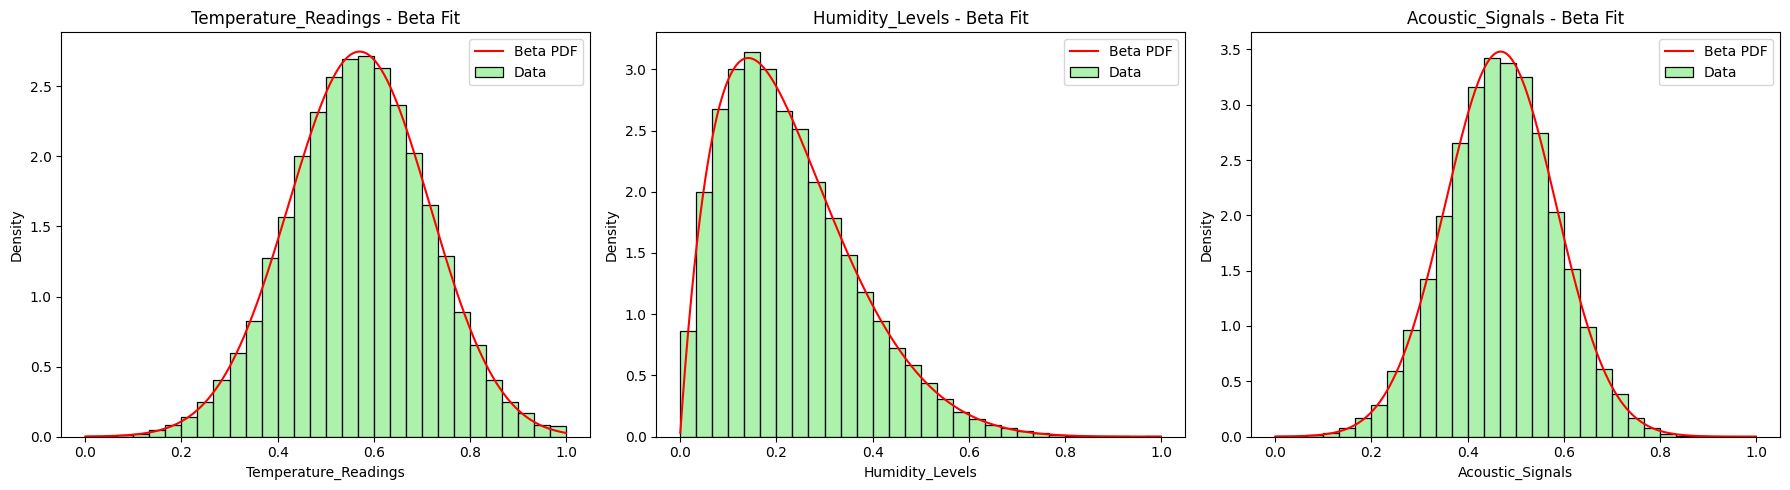

In [ ]:
def beta_params(data):
    scaled_data = (data - np.min(data)) / (np.max(data) - np.min(data))
    a, b, loc, scale = beta.fit(scaled_data)
    return a, b, loc, scale, scaled_data

columns = ["Temperature_Readings", "Humidity_Levels", "Acoustic_Signals"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  

for i, col in enumerate(columns):
    a, b, loc, scale, scaled_data = beta_params(df[col])

    print(f"Estimated parameters for {col}: a={a:.3f}, b={b:.3f}, loc={loc:.3f}, scale={scale:.3f}")

    sns.histplot(scaled_data, kde=False, stat="density", bins=30,color="lightgreen", label="Data", ax=axes[i])

    x = np.linspace(0, 1, 1000)
    pdf = beta.pdf(x, a, b, loc=loc, scale=scale)
    axes[i].plot(x, pdf, 'r-', label='Beta PDF')

    axes[i].set_title(f"{col} - Beta Fit")
    axes[i].legend()

plt.tight_layout()
plt.show()


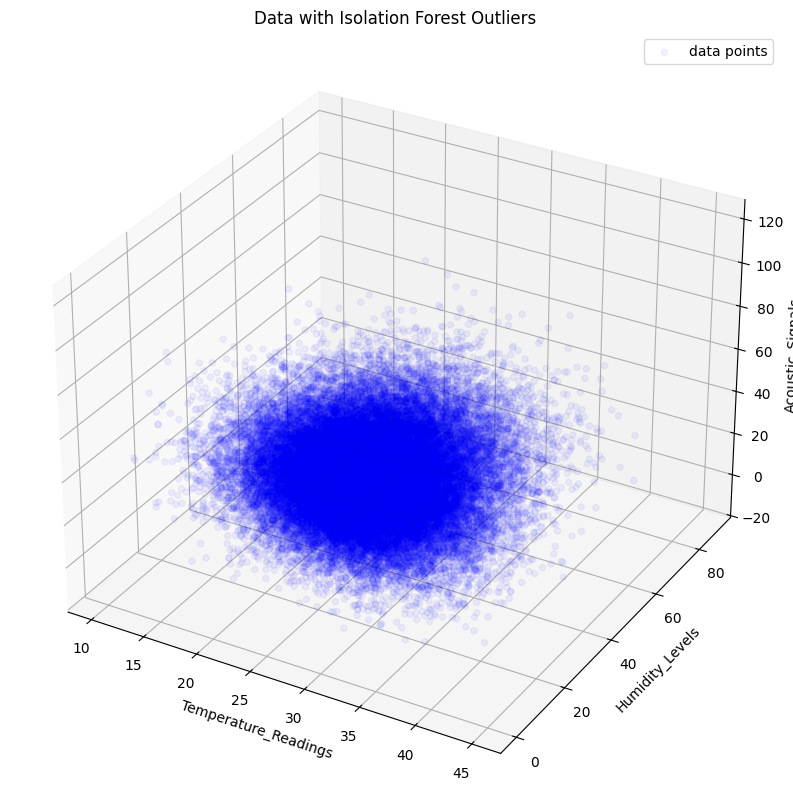

In [ ]:
# 3D Plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df["Temperature_Readings"], 
           df["Humidity_Levels"], 
           df["Acoustic_Signals"],label="data points", alpha=0.05, c='blue', marker='o')

ax.set_xlabel("Temperature_Readings")
ax.set_ylabel("Humidity_Levels")
ax.set_zlabel("Acoustic_Signals")
ax.set_title('Data with Isolation Forest Outliers')
ax.legend()

plt.show()

# Model Training

In [74]:
# Load sample data
X = df[["Temperature_Readings", "Humidity_Levels", "Acoustic_Signals"]]

# Train Isolation Forest
model = IsolationForest(contamination=0.001, random_state=42)
model.fit(X)

# Predict
df['anomaly'] = model.predict(X)
df['score'] = model.decision_function(X)

print(" Model trained ")

 Model trained 


In [75]:
score = silhouette_score(df[["Temperature_Readings", "Humidity_Levels", "Acoustic_Signals"]], df['anomaly'])
print("Silhouette Score:", score)

Silhouette Score: 0.5071558831818177


Silhouette score is 0.5 indicating that there is reasonable structure

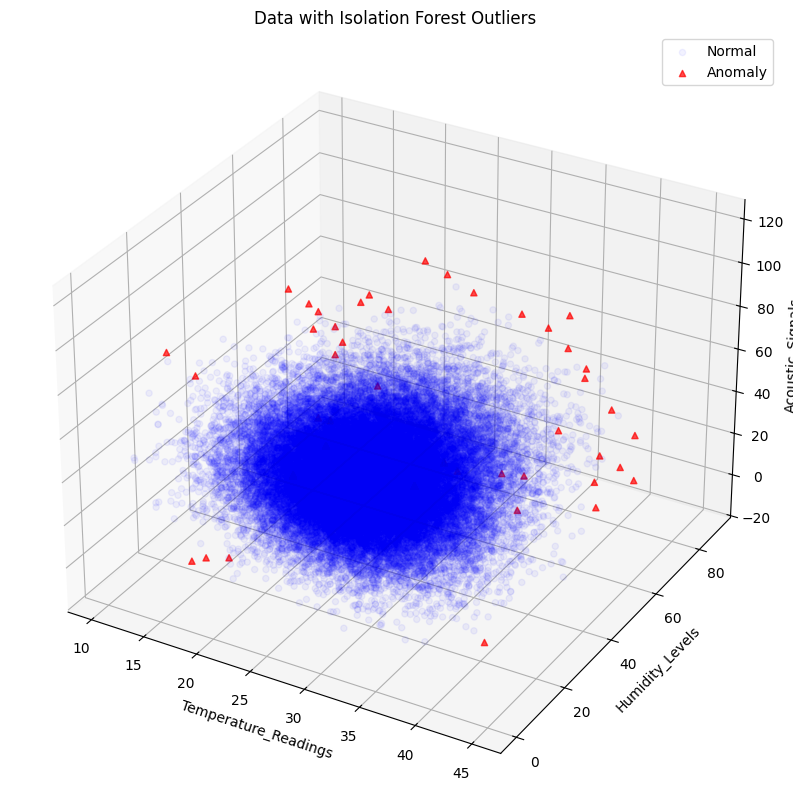

In [ ]:
# Visualize anomalies
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df[df['anomaly'] == 1]["Temperature_Readings"], 
           df[df['anomaly'] == 1]["Humidity_Levels"], 
           df[df['anomaly'] == 1]["Acoustic_Signals"], 
           label="Normal", alpha=0.05, c='blue', marker='o')

ax.scatter(df[df['anomaly'] == -1]["Temperature_Readings"], 
           df[df['anomaly'] == -1]["Humidity_Levels"], 
           df[df['anomaly'] == -1]["Acoustic_Signals"], 
           label="Anomaly", alpha=0.7, c='red', marker='^')

ax.set_xlabel("Temperature_Readings")
ax.set_ylabel("Humidity_Levels")
ax.set_zlabel("Acoustic_Signals")
ax.set_title('Data with Isolation Forest Outliers')
ax.legend()

plt.show()

In [ ]:
# Use model to predict
test={'Temperature_Readings': 10, 'Humidity_Levels': 89, 'Acoustic_Signals': -6} 

features = pd.DataFrame([test])

result=model.predict(features)[0]
score = model.decision_function(features)[0]
print('result=',result, '; score=',score)

result= -1 ; score= -0.09805337236858402
